# For classification...
using titanic dataset

# Libraries

In [1]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import time
import datetime
import os
import sys
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
import plotly.figure_factory as ff
import plotly.express as px
import missingno as msno

sns.set_context("talk")
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
style.use('fivethirtyeight')

# custom EDA functions
mypath = os.getcwd()
sys.path.append(mypath + '/code/') 
from utils import reduce_mem_usage, plot_target
from categorical_encoder import label_encoding
from feature_converter import categorize_features
from catplot import CategoricalVisualizer
from denseplot import DenseVisualizer

# custom modeling functions
sys.path.append(mypath + '/models/') 
from run_models import RunModel
from lgb_param_models import lgb_model
from xgb_param_models import xgb_model
from catb_param_models import catb_model
from lin_param_models import lin_model
from nn_param_models import nn_model

# stats
from scipy import stats
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import train_test_split
import scipy as sp
from functools import partial
from collections import Counter

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

print("libraries imported")

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.

Using TensorFlow backend.


libraries imported


# Load data

In [2]:
!ls

EDA_houseprice.ipynb README.md            inputs
EDA_titanic.ipynb    code                 models


In [3]:
# check path
datapath = "inputs/"
files = os.listdir(datapath)
print(files)

['.DS_Store', 'atma2020', 'house-prices-advanced-regression-techniques', 'titanic']


In [4]:
datapath = datapath + 'titanic'
os.listdir(datapath)

['test.csv', 'train.csv', 'gender_submission.csv']

In [5]:
# import data
time0 = time.time()

train = pd.read_csv(datapath + '/train.csv')
test = pd.read_csv(datapath + '/test.csv')
submission = pd.read_csv(datapath + '/gender_submission.csv')

time1 = time.time()
print(time1 - time0, " seconds to load data")

0.020323991775512695  seconds to load data


In [6]:
# check train
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# check test
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
# check submission file
print(submission.shape)
submission.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# EDA

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

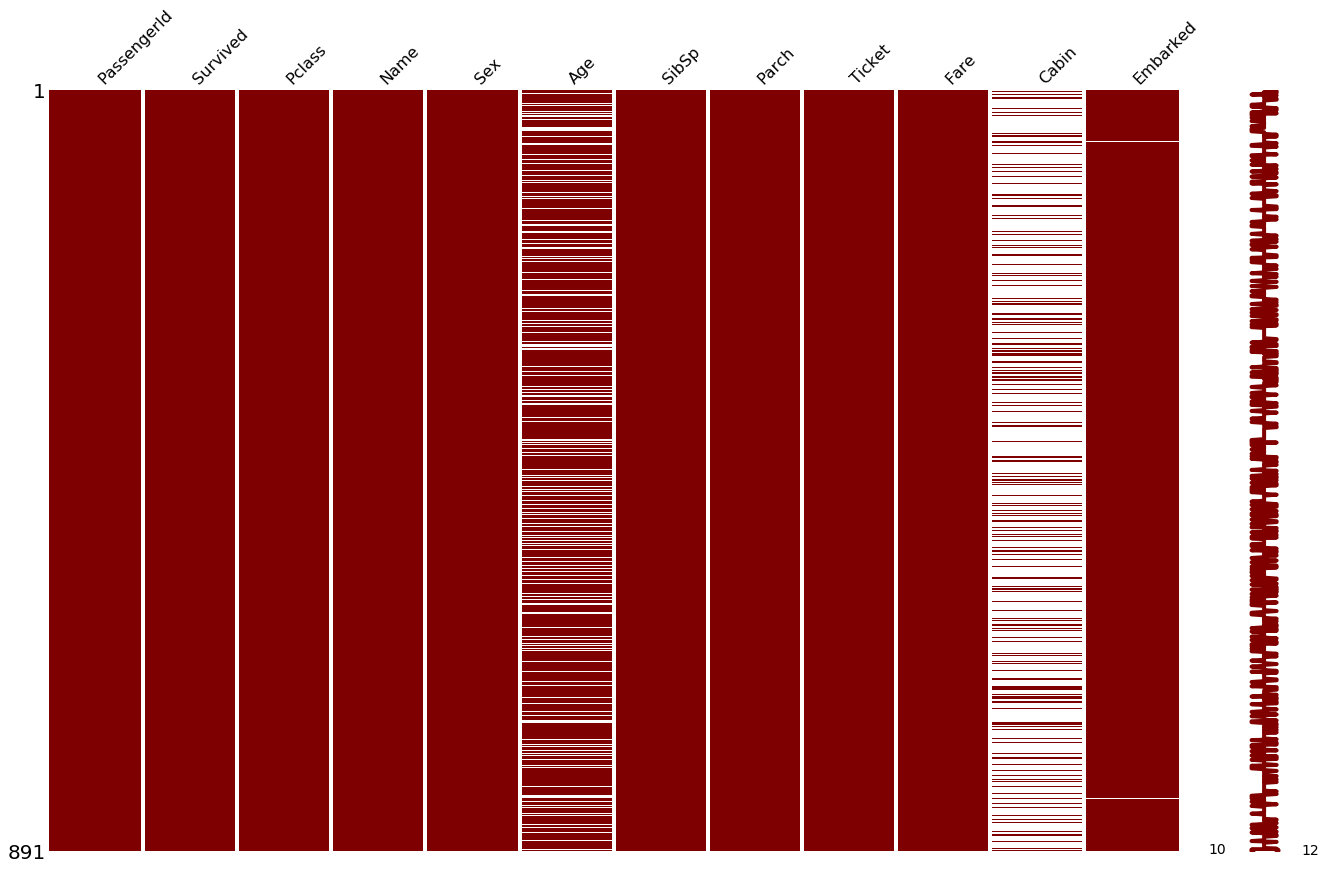

In [11]:
# missing data?
import missingno as msno
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

# Target

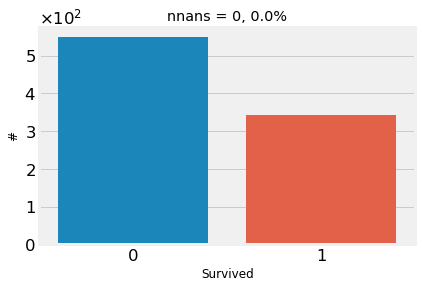

In [12]:
# hist
target = "Survived"
plot_target(train, target, objective="classification")

In [13]:
# roughly categorize features
features, dense_features, cat_features = categorize_features(train, target, cat_threshold=12)

There are 11 features.
There are 3 dense features.
There are 8 categorical features.


# Dense features

In [14]:
vd = DenseVisualizer(train=train, test=test, features=dense_features, target=target)
chkd = vd.column_checker()

feature name = PassengerId
feature name = Age
feature name = Fare


In [15]:
chkd.style.background_gradient()

,features,train_nans,test_nans,train_nunique,test_nunique,train_min,test_min,train_max,test_max,train_mean,test_mean,train_skew,test_skew
0,PassengerId,0,0,891,418,1,892,891,1309,446,1100.5,0,0
1,Age,177,86,88,79,0.42,0.17,80,76,29.6991,30.2726,0.389108,0.457361
2,Fare,0,1,248,169,0,0,512.329,512.329,32.2042,35.6272,4.78732,3.68721


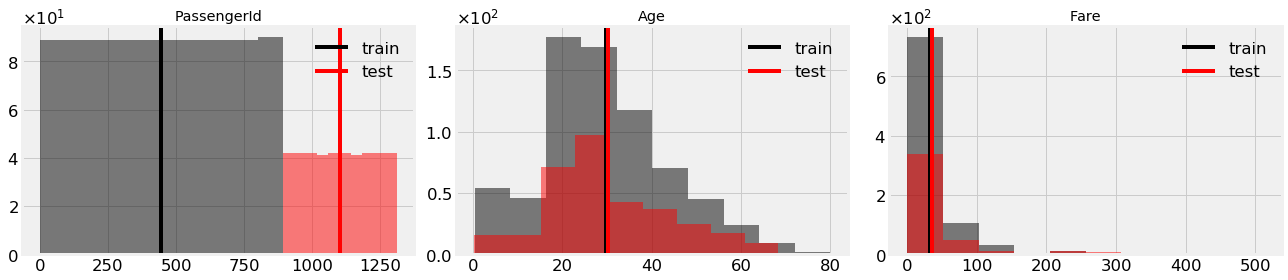

In [16]:
vd.plot_bars()

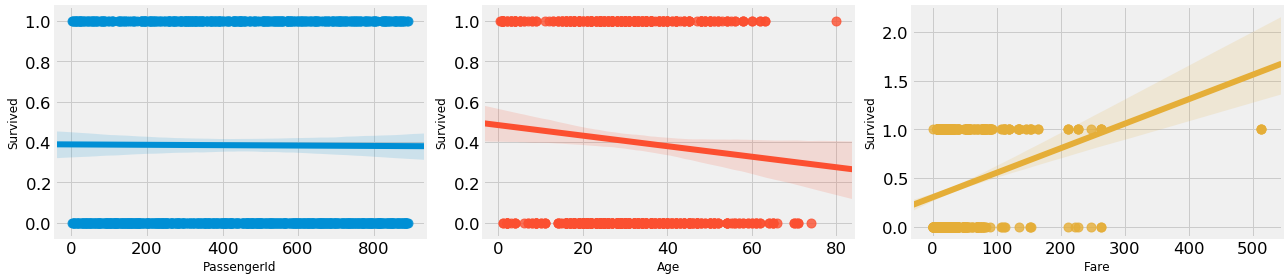

In [17]:
vd.plot_vs_target()

# Categorical features

In [18]:
# EDA for categorical features
vc = CategoricalVisualizer(train=train, test=test, features=cat_features, target=target)
chkc = vc.column_checker()

feature name = Pclass
feature name = Name
feature name = Sex
feature name = SibSp
feature name = Parch
feature name = Ticket
feature name = Cabin
feature name = Embarked


In [19]:
chkc.style.background_gradient()

,features,overlap,train_nans,test_nans,train_nunique,test_nunique
0,Pclass,1,0,0,3,3
1,Name,0.681714,0,0,891,418
2,Sex,1,0,0,2,2
3,SibSp,1,0,0,7,7
4,Parch,0.875,0,0,7,8
5,Ticket,0.733046,0,0,681,363
6,Cabin,0.786096,687,327,147,76
7,Embarked,0.75,2,0,3,3


In [20]:
# remove categorical features which have different values between train and test
cat_features = [c for c in cat_features if chkc.loc[chkc["features"] == c, "overlap"].iloc[0] == 1]
print(len(cat_features))
cat_features

3


['Pclass', 'Sex', 'SibSp']

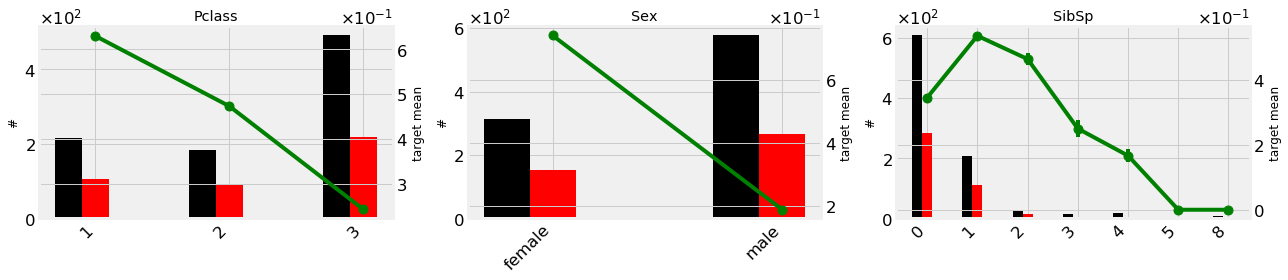

In [21]:
vc = CategoricalVisualizer(train=train, test=test, features=cat_features, target=target)
vc.plot_bars()

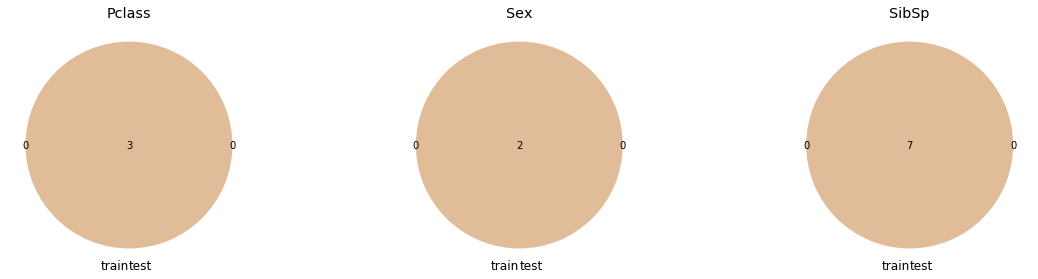

In [22]:
vc.plot_venn()

# Fit LGB and Get Feature importance

In [23]:
# label encoding object features
train, test, cat_features = label_encoding(train, test, cat_features)

In [24]:
train[target].isna().sum()

0

In [25]:
features = dense_features + cat_features
target in features

False

In [26]:
# fit LGB
lgbm = RunModel(train, test, target, features, categoricals=cat_features, n_splits=5,
                model="lgb", task="binary", cv_method="StratifiedKFold", seed=1220)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	training's auc: 0.922247	valid_1's auc: 0.841897
Partial score of fold 0 is: 0.841897233201581
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[656]	training's auc: 0.943858	valid_1's auc: 0.852437
Partial score of fold 1 is: 0.852437417654809
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[656]	training's auc: 0.943767	valid_1's auc: 0.856885
Partial score of fold 2 is: 0.8568850267379678
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[29]	training's auc: 0.845572	valid_1's auc: 0.897193
Partial score of fold 3 is: 0.8971925133689839
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[412]	training's auc: 0.91887	valid_1's auc: 0.899622
Partial score of fold 4 is: 0.8996222342147868
Our oof l

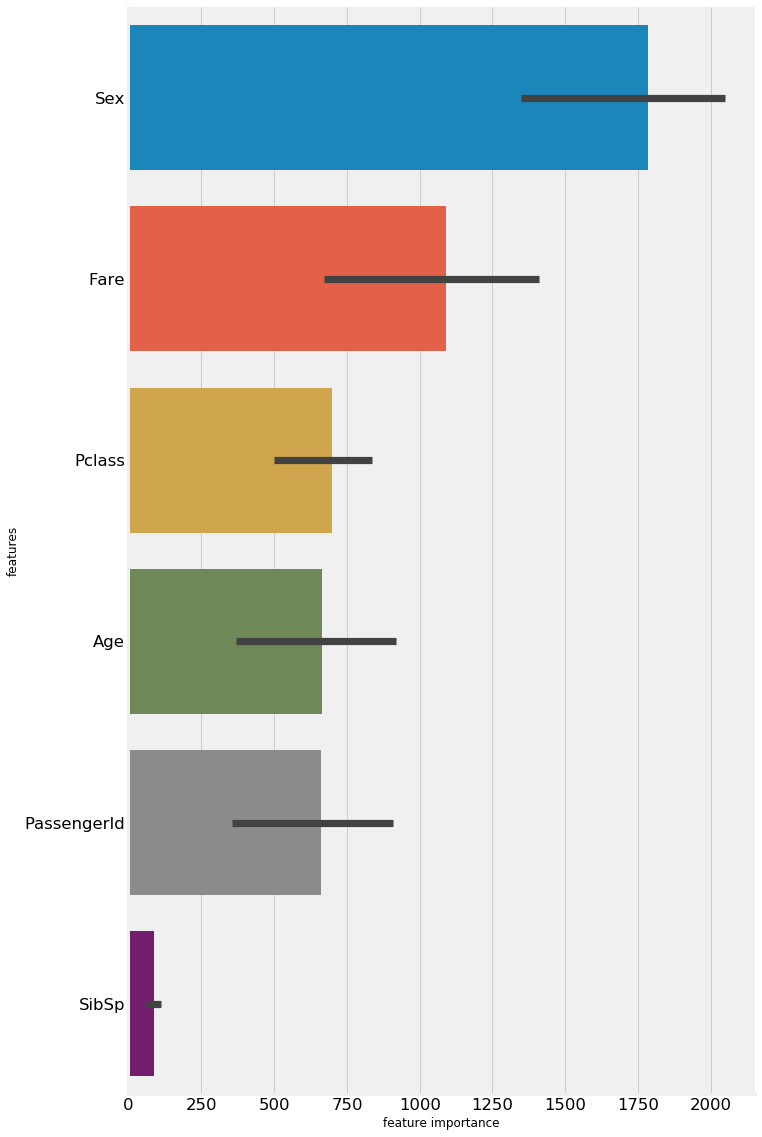

In [27]:
# plot feature importance
lgb_fi_df = lgbm.plot_feature_importance(rank_range=[1,30])

In [28]:
# fit CB
lgbm = RunModel(train, test, target, features, categoricals=cat_features, n_splits=5,
                model="catb", task="binary", cv_method="StratifiedKFold", seed=1220)

0:	learn: 0.6889004	test: 0.6889782	best: 0.6889782 (0)	total: 60.7ms	remaining: 2m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4191179496
bestIteration = 359

Shrink model to first 360 iterations.
Partial score of fold 0 is: 0.7851778656126482
0:	learn: 0.6889004	test: 0.6889782	best: 0.6889782 (0)	total: 594us	remaining: 1.19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4263881975
bestIteration = 140

Shrink model to first 141 iterations.
Partial score of fold 1 is: 0.7905797101449274
0:	learn: 0.6808422	test: 0.6813158	best: 0.6813158 (0)	total: 2.31ms	remaining: 4.61s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4336102322
bestIteration = 182

Shrink model to first 183 iterations.
Partial score of fold 2 is: 0.7780748663101604
0:	learn: 0.6799074	test: 0.6770930	best: 0.6770930 (0)	total: 2.98ms	remaining: 5.96s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3970788701
bestIteration =

In [29]:
# fit XGB
lgbm = RunModel(train, test, target, features, categoricals=cat_features, n_splits=5,
                model="xgb", task="binary", cv_method="StratifiedKFold", seed=1220)

[0]	validation_0-auc:0.54585
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[28]	validation_0-auc:0.828854

Partial score of fold 0 is: 0.7181159420289857
[0]	validation_0-auc:0.560013
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[3]	validation_0-auc:0.829974

Partial score of fold 1 is: 0.6983530961791832
[0]	validation_0-auc:0.571925
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[229]	validation_0-auc:0.838102

Partial score of fold 2 is: 0.7693850267379679
[0]	validation_0-auc:0.504947
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[83]	validation_0-auc:0.892647

Partial score of fold 3 is: 0.7798128342245989
[0]	validation_0-auc:0.521924
Will train until validation_0-auc hasn't improved in 100 rounds.
Stopping. Best iteration:
[408]	validation_0-auc:0.87075

Partial score of fold 4 is: 0.8236643281165676
O

In [32]:
# fit Linear
lgbm = RunModel(train, test, target, features, categoricals=cat_features, n_splits=5,
                model="linear", task="binary", cv_method="StratifiedKFold", scaler="Standard", seed=1220)

Partial score of fold 0 is: 0.7415678524374176
Partial score of fold 1 is: 0.765151515151515
Partial score of fold 2 is: 0.7648395721925134
Partial score of fold 3 is: 0.8152406417112299
Partial score of fold 4 is: 0.7850782514840798
Our oof loss score is:  0.7742066915923689


In [33]:
# fit NN
lgbm = RunModel(train, test, target, features, categoricals=cat_features, n_splits=5,
                model="nn", task="binary", cv_method="StratifiedKFold", scaler="MinMax", seed=1220)

Train on 712 samples, validate on 179 samples
Epoch 1/80
712/712 [==============================] - ETA: 6s - loss: 0.775 - 2s 2ms/step - loss: 0.7336 - val_loss: 0.6958
Epoch 2/80
712/712 [==============================] - ETA: 0s - loss: 0.719 - 0s 88us/step - loss: 0.7007 - val_loss: 0.6874
Epoch 3/80
712/712 [==============================] - ETA: 0s - loss: 0.715 - 0s 81us/step - loss: 0.7006 - val_loss: 0.6758
Epoch 4/80
712/712 [==============================] - ETA: 0s - loss: 0.747 - 0s 80us/step - loss: 0.6793 - val_loss: 0.6646
Epoch 5/80
712/712 [==============================] - ETA: 0s - loss: 0.708 - 0s 82us/step - loss: 0.6686 - val_loss: 0.6585
Epoch 6/80
712/712 [==============================] - ETA: 0s - loss: 0.652 - 0s 83us/step - loss: 0.6612 - val_loss: 0.6534
Epoch 7/80
712/712 [==============================] - ETA: 0s - loss: 0.636 - 0s 85us/step - loss: 0.6413 - val_loss: 0.6497
Epoch 8/80
712/712 [==============================] - ETA: 0s - loss: 0.581 - 0s

Epoch 66/80
712/712 [==============================] - ETA: 0s - loss: 0.434 - 0s 91us/step - loss: 0.4664 - val_loss: 0.4995
Epoch 67/80
712/712 [==============================] - ETA: 0s - loss: 0.455 - 0s 91us/step - loss: 0.4583 - val_loss: 0.4984
Epoch 68/80
712/712 [==============================] - ETA: 0s - loss: 0.405 - 0s 91us/step - loss: 0.4644 - val_loss: 0.4987
Epoch 69/80
712/712 [==============================] - ETA: 0s - loss: 0.440 - 0s 92us/step - loss: 0.4572 - val_loss: 0.4972
Epoch 70/80
712/712 [==============================] - ETA: 0s - loss: 0.438 - 0s 91us/step - loss: 0.4588 - val_loss: 0.4962
Epoch 71/80
712/712 [==============================] - ETA: 0s - loss: 0.477 - 0s 92us/step - loss: 0.4542 - val_loss: 0.4951
Epoch 72/80
712/712 [==============================] - ETA: 0s - loss: 0.419 - 0s 91us/step - loss: 0.4540 - val_loss: 0.4954
Epoch 73/80
712/712 [==============================] - ETA: 0s - loss: 0.440 - 0s 93us/step - loss: 0.4507 - val_loss:

Epoch 50/80
712/712 [==============================] - ETA: 0s - loss: 0.496 - 0s 96us/step - loss: 0.4705 - val_loss: 0.4943
Epoch 51/80
712/712 [==============================] - ETA: 0s - loss: 0.515 - 0s 99us/step - loss: 0.4779 - val_loss: 0.4933
Epoch 52/80
712/712 [==============================] - ETA: 0s - loss: 0.462 - 0s 96us/step - loss: 0.4714 - val_loss: 0.4934
Epoch 53/80
712/712 [==============================] - ETA: 0s - loss: 0.544 - 0s 96us/step - loss: 0.4607 - val_loss: 0.4950
Epoch 54/80
712/712 [==============================] - ETA: 0s - loss: 0.425 - 0s 97us/step - loss: 0.4820 - val_loss: 0.4911
Epoch 55/80
712/712 [==============================] - ETA: 0s - loss: 0.408 - 0s 95us/step - loss: 0.4611 - val_loss: 0.4907
Epoch 56/80
712/712 [==============================] - ETA: 0s - loss: 0.463 - 0s 96us/step - loss: 0.4706 - val_loss: 0.4858
Epoch 57/80
712/712 [==============================] - ETA: 0s - loss: 0.454 - 0s 96us/step - loss: 0.4666 - val_loss:

713/713 [==============================] - ETA: 0s - loss: 0.424 - 0s 108us/step - loss: 0.4878 - val_loss: 0.4763
Epoch 35/80
713/713 [==============================] - ETA: 0s - loss: 0.409 - 0s 97us/step - loss: 0.4874 - val_loss: 0.4747
Epoch 36/80
713/713 [==============================] - ETA: 0s - loss: 0.361 - 0s 97us/step - loss: 0.4765 - val_loss: 0.4742
Epoch 37/80
713/713 [==============================] - ETA: 0s - loss: 0.514 - 0s 100us/step - loss: 0.4806 - val_loss: 0.4732
Epoch 38/80
713/713 [==============================] - ETA: 0s - loss: 0.496 - 0s 97us/step - loss: 0.4880 - val_loss: 0.4733
Epoch 39/80
713/713 [==============================] - ETA: 0s - loss: 0.478 - 0s 98us/step - loss: 0.4844 - val_loss: 0.4716
Epoch 40/80
713/713 [==============================] - ETA: 0s - loss: 0.509 - 0s 97us/step - loss: 0.4894 - val_loss: 0.4711
Epoch 41/80
713/713 [==============================] - ETA: 0s - loss: 0.485 - 0s 99us/step - loss: 0.4705 - val_loss: 0.4699
Ep

713/713 [==============================] - ETA: 0s - loss: 0.552 - 0s 101us/step - loss: 0.5747 - val_loss: 0.5431
Epoch 19/80
713/713 [==============================] - ETA: 0s - loss: 0.562 - 0s 101us/step - loss: 0.5736 - val_loss: 0.5375
Epoch 20/80
713/713 [==============================] - ETA: 0s - loss: 0.529 - 0s 100us/step - loss: 0.5755 - val_loss: 0.5308
Epoch 21/80
713/713 [==============================] - ETA: 0s - loss: 0.601 - 0s 101us/step - loss: 0.5693 - val_loss: 0.5253
Epoch 22/80
713/713 [==============================] - ETA: 0s - loss: 0.554 - 0s 99us/step - loss: 0.5678 - val_loss: 0.5186
Epoch 23/80
713/713 [==============================] - ETA: 0s - loss: 0.521 - 0s 100us/step - loss: 0.5520 - val_loss: 0.5125
Epoch 24/80
713/713 [==============================] - ETA: 0s - loss: 0.526 - 0s 100us/step - loss: 0.5533 - val_loss: 0.5072
Epoch 25/80
713/713 [==============================] - ETA: 0s - loss: 0.511 - 0s 100us/step - loss: 0.5473 - val_loss: 0.50

Epoch 2/80
714/714 [==============================] - ETA: 0s - loss: 0.734 - 0s 87us/step - loss: 0.7055 - val_loss: 0.6905
Epoch 3/80
714/714 [==============================] - ETA: 0s - loss: 0.692 - 0s 93us/step - loss: 0.6890 - val_loss: 0.6808
Epoch 4/80
714/714 [==============================] - ETA: 0s - loss: 0.653 - 0s 96us/step - loss: 0.6799 - val_loss: 0.6744
Epoch 5/80
714/714 [==============================] - ETA: 0s - loss: 0.705 - 0s 98us/step - loss: 0.6738 - val_loss: 0.6671
Epoch 6/80
714/714 [==============================] - ETA: 0s - loss: 0.623 - 0s 100us/step - loss: 0.6781 - val_loss: 0.6617
Epoch 7/80
714/714 [==============================] - ETA: 0s - loss: 0.681 - 0s 99us/step - loss: 0.6573 - val_loss: 0.6532
Epoch 8/80
714/714 [==============================] - ETA: 0s - loss: 0.651 - 0s 101us/step - loss: 0.6495 - val_loss: 0.6485
Epoch 9/80
714/714 [==============================] - ETA: 0s - loss: 0.646 - 0s 101us/step - loss: 0.6533 - val_loss: 0.64

Epoch 67/80
714/714 [==============================] - ETA: 0s - loss: 0.526 - 0s 109us/step - loss: 0.4810 - val_loss: 0.4682
Epoch 68/80
714/714 [==============================] - ETA: 0s - loss: 0.449 - 0s 110us/step - loss: 0.4633 - val_loss: 0.4671
Epoch 69/80
714/714 [==============================] - ETA: 0s - loss: 0.485 - 0s 108us/step - loss: 0.4656 - val_loss: 0.4647
Epoch 70/80
714/714 [==============================] - ETA: 0s - loss: 0.442 - 0s 110us/step - loss: 0.4637 - val_loss: 0.4675
Epoch 71/80
714/714 [==============================] - ETA: 0s - loss: 0.429 - 0s 110us/step - loss: 0.4614 - val_loss: 0.4627
Epoch 72/80
714/714 [==============================] - ETA: 0s - loss: 0.449 - 0s 110us/step - loss: 0.4590 - val_loss: 0.4619
Epoch 73/80
714/714 [==============================] - ETA: 0s - loss: 0.509 - 0s 109us/step - loss: 0.4755 - val_loss: 0.4641
Epoch 74/80
714/714 [==============================] - ETA: 0s - loss: 0.427 - 0s 108us/step - loss: 0.4669 - v